# Disease lethality prediction

### Feature engineering and the curse of dimensionality

With this notebook we give a brief introduction to feature engineering on relational data with *many columns.* We discuss why feature engineering on such data is *particularly challenging* and what we can do to overcome these problems.

Summary:

- Prediction type: __Binary classification__
- Domain: __Health__
- Prediction target: __Mortality within one year__ 
- Source data: __146 columns in 2 tables, 22 MB__
- Population size: __28433__

_Author: Dr. Patrick Urbanke_

#### __The problem__

To illustrate the point, we give a simplified example based on the real data used in the analysis below. When we engineer features from relational data, we usually write something like this:

```sql
SELECT AVG(t2.HDL)
FROM population_training t1
LEFT JOIN contr t2
ON t1.ICO = t2.ICO
WHERE t1.AGE >= 60 AND t1.ALOKOHOL IN ('1', '2')
GROUP BY t1.ICO;
```

Think about that for a second. This feature aggregates high-density lipoprotein (HDL) cholesterol values recorded during control dates conditional on age and alcohol consumption. We arbitrarily chose both, the column to aggregate over *(HDL)*  and the set of columns to construct conditions on *(AGE* and *ALKOHOL)* out of a greater set of 146 columns.

Every column that we have can either be aggregated (here *HDL)* or it can be used for our conditions (here *AGE* and *ALKOHOL)*. That means if we have *n* columns to aggregate, we can potentially build conditions for $n$ other columns. In other words, the computational complexity is $n^2$ in the number of columns.

Note that this problem occurs regardless of whether you automate feature engineering or you do it by hand. The size of the search space is $n^2$ in the number of columns in either case, unless you can rule something out a-priori.




#### __The solution__

So when we have relational data sets with many columns, what do we do? The answer is to write different features. Specifically, suppose we had features like this:

```sql
SELECT AVG(
    CASE WHEN t1.AGE >= THEN weight1
    CASE WHEN t1.ALKOHOL IN ('1', '2') THEN weight2
    END
)
FROM population_training t1
LEFT JOIN contr t2
ON t1.ICO = t2.ICO
GROUP BY t1.ICO;
```

*weight1* and *weight2* are learnable weights. An algorithm that generates features like this can only use columns for conditions, it is not allowed to aggregate columns – and it doesn't need to do so.

That means the computational complexity is linear instead of quadratic. For data sets with a large number of columns this can make all the difference in the world. For instance, if you have 100 columns the size of the search space of the second approach is only 1% of the size of the search space of the first one.



# Background

To illustrate the problem of dimensionality in predictive analytics on relational data, we use the STULONG 1 dataset. It is a longitudinal study of atherosclerosis patients.

One of its defining features is that it contains many columns, which makes it a good candidate to illustrate the problem discussed in this notebook.

The are some academic studies related to this dataset:

* https://www.researchgate.net/publication/228572841_Mining_episode_rules_in_STULONG_dataset
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.83.4764&rep=rep1&type=pdf

The way these studies handle the large number of columns in the data set is to divide the columns into subgroups and then handling each subgroup separately. Even though this is one way to overcome the curse of dimensionality, it is not a very satisfying approach. We would like to be able to handle a large number of columns at once.


The analysis is based on the STULONG 1 dataset. It is publicly available and can be downloaded the [the CTU Prague Relational Learning Repository](https://relational.fit.cvut.cz/dataset/Atherosclerosis).



### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# The analysis

Let's get started with the analysis and set-up your session:

In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image, Markdown
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project('atherosclerosis')

getML API version: 0.12.0-datasets.3

Loading existing project 'atherosclerosis'


## 1. Loading data


### 1.1 Download from source

Downloading the raw data and convert it into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It is made available in the example notebook featuring the full analysis.

In [2]:
data = getml.datasets.load_atherosclerosis(roles=True)
population_training, _, population_testing, contr = data.values()

### 1.2 Prepare data for getML

The `getml.datasets.load_atherosclerosis` method took care of the entire data lifting:
* Downloads csv's from our servers in python
* Converts csv's to getML [DataFrames]()
* Sets [roles]() to columns inside getML DataFrames

__Data visualization__

The original data (image below) model is condensed into 2 tables: 

* A population table *population_{train/test/validate}*, based on `death` table
* A peripheral table: `contr`.

__Death:__ population table

* Reference Date: Period of time from 1976 to 1999
* Target: If the patient dies within one year after each reference date


In [3]:
# print getML DataFrame
population_training

Name,REFERENCE_DATE,ENTRY_DATE,ICO,TARGET,KONSKUP,STAV,VZDELANI,ZODPOV,TELAKTZA,AKTPOZAM,DOPRAVA,DOPRATRV,ALKOHOL,BOLHR,BOLDK,DUSNOST,RARISK,OBEZRISK,KOURRISK,HTRISK,CHOLRISK,MOC,AGE,PARTICIPATION,VYSKA,VAHA,SYST1,DIAST1,SYST2,DIAST2,TRIC,SUBSC,CHLST,TRIGL,KOURENI,DOBAKOUR,BYVKURAK,PIVOMN,VINOMN,LIHMN,KAVA,CAJ,CUKR,Unnamed: 0_x,ROKNAR,ROKVSTUP,MESVSTUP,PIVO7,PIVO10,PIVO12,VINO,LIHOV,IM,IML,HT,HTD,HTL,ICT,ICTL,DIABET,DIABD,DIABL,HYPLIP,HYPLD,HYPLL,IMTRV,HTTRV,ICTTRV,DIABTRV,HYPLTRV,Unnamed: 0_y,DENUMR,MESUMR,ROKUMR,PRICUMR,DUMMY,YEAR,DEATH_DATE
Role,time_stamp,time_stamp,join_key,target,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
Unit,"time stamp, comparison only","time stamp, comparison only",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1989-01-01T00:00:00.000000Z,1977-02-01T00:00:00.000000Z,20343,0,6,1,2,2,1,2,3,6,2,1,1,1,0,0,0,0,1,1,62,-1888,172,74,150,90,150,95,10,32,300,240,5,9,12,2,4,7,2,5,2,1335,27,1977,2,nan,9,nan,nan,nan,2,nan,2,nan,nan,2,nan,2,nan,nan,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1989,nan
1,1991-01-01T00:00:00.000000Z,1977-04-01T00:00:00.000000Z,10628,0,3,1,4,3,1,2,9,9,2,2,1,1,0,0,0,1,1,1,63,-1886,180,84,160,95,160,95,8,21,374,155,2,7,12,2,5,8,2,5,3,625,28,1977,4,nan,9,nan,11,12,2,nan,2,nan,nan,2,nan,2,nan,nan,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1991,nan
2,1994-01-01T00:00:00.000000Z,1977-04-01T00:00:00.000000Z,10039,0,4,1,2,3,4,1,3,5,2,2,1,1,1,1,0,0,1,1,60,-1883,180,92,120,80,120,75,9,26,280,143,3,7,12,2,5,7,2,5,3,38,34,1977,4,nan,9,nan,11,nan,2,nan,2,nan,nan,2,nan,2,nan,nan,6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1994,nan
3,1987-01-01T00:00:00.000000Z,1976-10-01T00:00:00.000000Z,20211,0,6,1,3,3,1,2,1,5,2,2,1,1,1,0,0,0,0,1,59,-1889,170,79,140,90,145,90,4,6,196,nan,1,nan,nan,2,5,8,2,4,1,1203,28,1976,10,nan,9,nan,11,12,2,nan,2,nan,nan,2,nan,2,nan,nan,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1987,nan
4,1987-01-01T00:00:00.000000Z,1977-09-01T00:00:00.000000Z,10952,0,3,1,2,3,4,2,1,5,3,1,1,1,0,0,1,1,0,1,53,-1890,182,82,140,95,140,95,6,13,242,65,4,10,nan,2,4,8,2,4,1,948,34,1977,9,nan,9,nan,nan,12,2,nan,2,nan,nan,2,nan,2,nan,nan,6,nan,nan,nan,nan,nan,nan,nan,300,1,11,1996,5,1,1987,1996-11-01
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19898,1980-01-01T00:00:00.000000Z,1977-04-01T00:00:00.000000Z,10047,0,4,1,2,1,1,2,3,5,3,1,1,1,0,0,0,1,1,1,46,-1897,177,87,130,90,150,100,11,31,327,157,1,nan,nan,2,6,7,2,5,8,46,34,1977,4,nan,nan,10,11,nan,2,nan,2,nan,nan,2,nan,2,nan,nan,6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1980,nan
19899,1981-01-01T00:00:00.000000Z,1977-03-01T00:00:00.000000Z,30037,0,5,1,3,2,1,1,3,6,2,3,1,2,1,0,1,1,0,1,47,-1896,165,74,115,75,115,75,8,20,233,541,5,9,nan,1,4,9,2,4,8,1390,34,1977,3,nan,nan,nan,nan,12,2,nan,1,6,4,2,nan,2,nan,nan,6,nan,nan,nan,15,nan,nan,nan,nan,nan,nan,nan,nan,1,1981,nan


__Contr:__ peripheral table



In [4]:
# print getML DataFrame
contr

Name,CONTROL_DATE,ICO,ZMTELAKT,AKTPOZAM,ZMDIET,LEKTLAK,ZMKOUR,POCCIG,PRACNES,JINAONE,BOLHR,BOLDK,DUSN,HODNSK,HYPERD,HYPCHL,HYPTGL,HMOT,CHLST,HDL,HDLMG,LDL,Unnamed: 0,ROKVYS,MESVYS,PORADK,ZMCHARZA,LEKCHOL,SRDCE,HYPERT,CEVMOZ,DIAB,HODN0,ROK0,HODN1,ROK1,HODN2,ROK2,HODN3,ROK3,HODN4,ROK4,HODN11,ROK11,HODN12,ROK12,HODN13,ROK13,HODN14,ROK14,HODN15,ROK15,HODN21,ROK21,HODN23,ROK23,SYST,DIAST,TRIC,SUBSC,HYPERSD,HYPERS,CHLSTMG,TRIGL,TRIGLMG,MOC,GLYKEMIE,KYSMOC
Role,time_stamp,join_key,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float
Unit,"time stamp, comparison only",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1977-09-01T00:00:00.000000Z,10001,3,2,1,2,2,0.0,1,2.0,1,1,1,2,2.0,2.0,2.0,71,5.61,nan,nan,nan,0,1977,9,1,20,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,130,90,4,12,2,2,217,1.22,108,1,nan,nan
1,1979-01-01T00:00:00.000000Z,10001,1,1,1,2,1,0.0,2,NULL,1,2,1,2,2.0,2.0,2.0,72,6,nan,nan,nan,1,1979,1,2,20,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,140,90,4,11,2,2,232,4.4,389,3,nan,nan
2,1980-04-01T00:00:00.000000Z,10001,2,1,1,2,1,0.0,2,NULL,2,1,1,2,2.0,2.0,2.0,71,6.23,nan,nan,nan,2,1980,4,3,20,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,130,90,5,22,2,2,241,1.51,134,1,nan,nan
3,1982-01-01T00:00:00.000000Z,10001,2,1,1,2,1,0.0,1,2.0,1,1,1,2,2.0,2.0,2.0,74,5.2,nan,nan,nan,3,1982,1,4,20,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,150,100,9,18,2,2,201,1.42,126,1,nan,nan
4,1983-02-01T00:00:00.000000Z,10001,2,2,1,2,1,0.0,2,NULL,1,2,1,2,2.0,2.0,2.0,73,6.08,1.47,57,4.15,4,1983,2,5,20,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,165,105,7,15,2,2,235,0.99,88,1,nan,nan
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10567,1987-10-01T00:00:00.000000Z,20358,2,2,1,2,1,0.0,2,NULL,4,1,1,3,2.0,2.0,2.0,85,4.89,0.98,38,3.11,10567,1987,10,1,20,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,120,80,nan,nan,2,2,189,1.74,154,1,nan,nan
10568,1987-11-01T00:00:00.000000Z,20359,2,2,1,2,1,14.0,2,NULL,1,1,1,3,2.0,2.0,2.0,80,4.5,0.98,38,3.16,10568,1987,11,1,20,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,100,70,nan,nan,2,2,174,0.79,70,1,nan,nan


### 1.3 Define relational model

To start with relational learning, we need to specify the data model. This is done abstractly using [Placeholders](https://docs.getml.com/latest/user_guide/data_model/data_model.html#placeholders):

* Each table in the data model requires a placeholder
* Placeholders are then joined together to define the abstract data model
* getML pipeline requires abstract data model during initialization

In [5]:
population_placeholder = getml.data.Placeholder("population")

contr_placeholder = getml.data.Placeholder("contr")

population_placeholder.join(
    contr_placeholder,
    join_key="ICO",
    time_stamp="REFERENCE_DATE",
    other_time_stamp="CONTROL_DATE"
)

## 2.Predictive modelling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 Test setup

To illustrate the problem of computational complexity, we fit two getML pipelines using different feature learning algorithms:

The __first pipeline__ uses `Multirel` and the __second pipeline__ uses `Relboost`.

To demonstrate the power of feature ensembling, we build a __third pipeline__ that uses both algorithms.


At the end, we compare the runtime and predictive accuracies of all three pipelines.

### 2.2 Relational learning using Multirel

We begin with MultirelModel. Features generated by MultirelModel suffer from quadratic complexity. Luckily, the number of columns is not too high, so it is still manageble.

In [6]:
multirel = getml.feature_learning.MultirelModel(
    num_features=30,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1
)

feature_selector = getml.predictors.XGBoostClassifier()

xgboost = getml.predictors.XGBoostClassifier(
    max_depth=5,
    reg_lambda=100.0,
    learning_rate=0.1
)

# Build the getML pipeline
pipe_1 = getml.pipeline.Pipeline(
    tags=["multirel only"],
    population=population_placeholder,
    peripheral=[contr_placeholder],
    feature_learners=multirel,
    feature_selectors=feature_selector,
    share_selected_features=0.8,
    predictors=xgboost,
    include_categorical=True
)

It always a good idea to check before fitting. There is one minor warning: This warning means that about 12% of patients never appear in **CONTR** (presumably because they never showed up to their health check-ups).

In [7]:
pipe_1.check(
    population_table=population_training,
    peripheral_tables=[contr]
)

INFO [JOIN KEYS NOT FOUND]: When joining 'population_train' and 'contr' over 'ICO' and 'ICO', there are no corresponding entries for 12.254434% of entries in join key 'ICO' in 'population_train'. You might want to double-check your join keys.


Checking data model...


We now **fit pipeline 1**.

In [8]:
pipe_1.fit(
    population_table=population_training,
    peripheral_tables=[contr]
)

INFO [JOIN KEYS NOT FOUND]: When joining 'population_train' and 'contr' over 'ICO' and 'ICO', there are no corresponding entries for 12.254434% of entries in join key 'ICO' in 'population_train'. You might want to double-check your join keys.


Checking data model...

MultirelModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:1m:3.677175



Pipeline(feature_learners=['MultirelModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=True, 
         peripheral=['contr'], population='population', 
         predictors=['XGBoostClassifier'], tags=['multirel only'], 
         share_selected_features=0.8)

url: /user/getml-getml-demo-k136c5z7/proxy/1709/getpipeline/N6xvz3/0/

As we can see, this around one minute.

### 2.3 Relational learning using Relboost

Let's see how well Relboost does. This algorithm has linear complexity in the number of columns.

In [9]:
relboost = getml.feature_learning.RelboostModel(
    num_features=30,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    min_num_samples=500,
    max_depth=2,
    num_threads=1
)

# We resuse the `xgboost` classifier from above

# Build the getML pipeline
pipe_2 = getml.pipeline.Pipeline(
    tags=["relboost only"],
    population=population_placeholder,
    peripheral=[contr_placeholder],
    feature_learners=relboost,
    feature_selectors=feature_selector,
    share_selected_features=0.8,    
    predictors=xgboost,
    include_categorical=True
)



We now fit pipeline 2.

In [10]:
pipe_2.fit(
    population_table=population_training,
    peripheral_tables=[contr]
)

Checking data model...


INFO [JOIN KEYS NOT FOUND]: When joining 'population_train' and 'contr' over 'ICO' and 'ICO', there are no corresponding entries for 12.254434% of entries in join key 'ICO' in 'population_train'. You might want to double-check your join keys.



RelboostModel: Training features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:40.936652



Pipeline(feature_learners=['RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=True, 
         peripheral=['contr'], population='population', 
         predictors=['XGBoostClassifier'], tags=['relboost only'], 
         share_selected_features=0.8)

url: /user/getml-getml-demo-k136c5z7/proxy/1709/getpipeline/2cQPMF/0/

Note that this runs through in well under a minute. This demonstrates the power of computational complexity theory. If we had more columns, the difference between these two algorithms would become even more noticable.

### 2.4 Relational learning using Multirel & Relboost

As Multirel and Relboost have distinct benefits, we can use both algorithms to build a feature ensemble.

In [11]:
# We reuse `multirel`, `relboost` and `xgboost` from above:

# Build the getML pipeline
pipe_3 = getml.pipeline.Pipeline(
    tags=["both multirel and relboost"],
    population=population_placeholder,
    peripheral=[contr_placeholder],
    feature_learners=[multirel, relboost],
    feature_selectors=feature_selector,
    share_selected_features=0.8,
    predictors=xgboost,
    include_categorical=True
)

We now fit pipeline 3.

In [12]:
pipe_3.fit(
    population_table=population_training,
    peripheral_tables=[contr]
)

Checking data model...


INFO [JOIN KEYS NOT FOUND]: When joining 'population_train' and 'contr' over 'ICO' and 'ICO', there are no corresponding entries for 12.254434% of entries in join key 'ICO' in 'population_train'. You might want to double-check your join keys.



Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:11.592714



Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=True, 
         peripheral=['contr'], population='population', 
         predictors=['XGBoostClassifier'], 
         tags=['both multirel and relboost'], share_selected_features=0.8)

url: /user/getml-getml-demo-k136c5z7/proxy/1709/getpipeline/ykKMHG/0/

### 2.5 Model evaluation

In [13]:
print("Scoring: pipe_1 (Multirel)")
score_1_train = pipe_1.score(
    population_table=population_training,
    peripheral_tables=[contr]
)
score_1_test = pipe_1.score(
    population_table=population_testing,
    peripheral_tables=[contr]
)

print("Scoring: pipe_2 (Relboost)")
score_2_train = pipe_2.score(
    population_table=population_training,
    peripheral_tables=[contr]
)
score_2_test = pipe_2.score(
    population_table=population_testing,
    peripheral_tables=[contr]
)

print("Scoring: pipe_3 (Multirel+Relboost)")
score_3_train = pipe_3.score(
    population_table=population_training,
    peripheral_tables=[contr]
)
score_3_test = pipe_3.score(
    population_table=population_testing,
    peripheral_tables=[contr]
)

Scoring: pipe_1 (Multirel)

MultirelModel: Building features...
[========================================] 100%


MultirelModel: Building features...
[========================================] 100%

Scoring: pipe_2 (Relboost)

RelboostModel: Building features...
[========================================] 100%


RelboostModel: Building features...
[========================================] 100%

Scoring: pipe_3 (Multirel+Relboost)

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%



### 2.6 Studying the features

It is always a good idea to study the features generated by the algorithms.

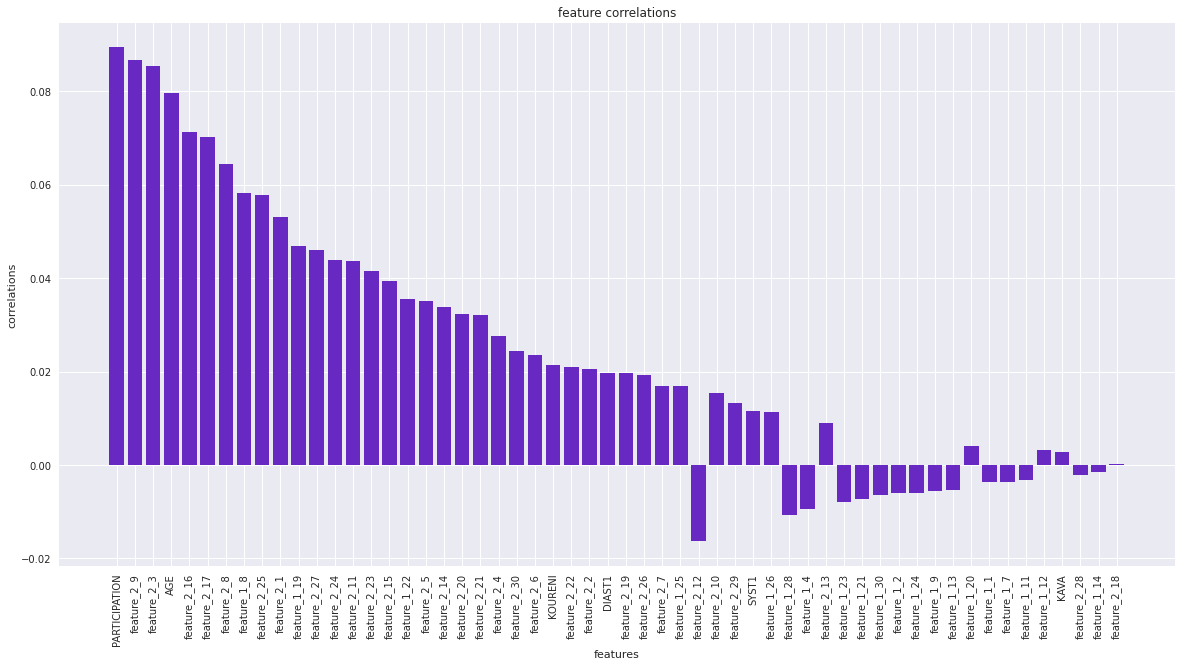

In [14]:
names, correlations = pipe_3.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

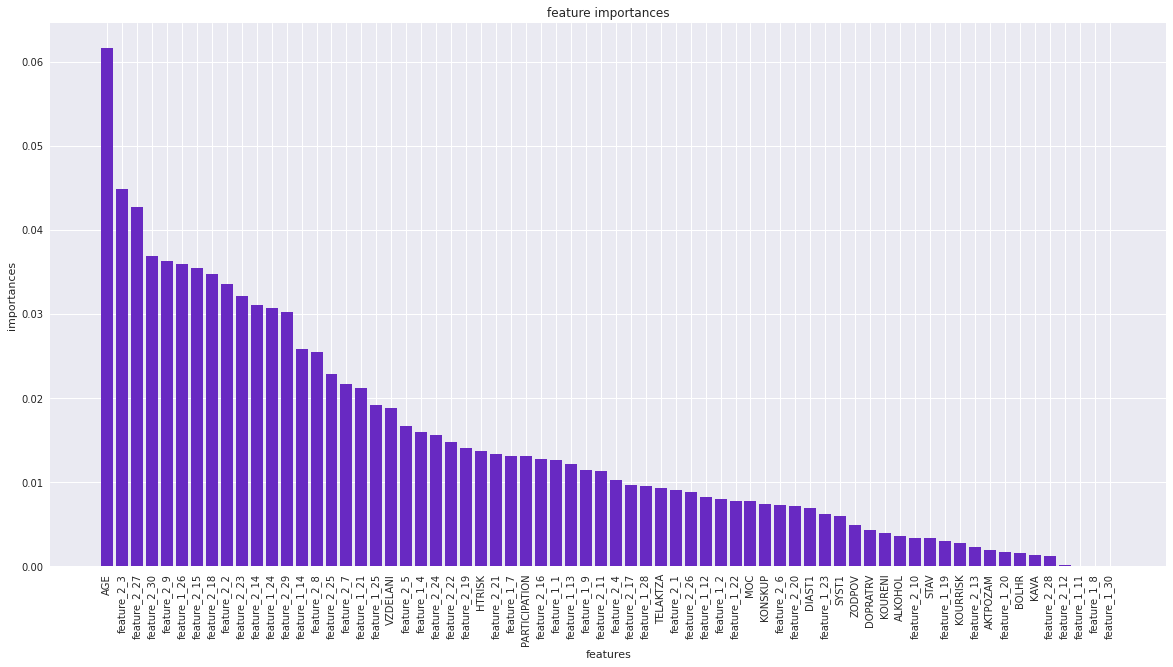

In [15]:
names, importances = pipe_3.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importances")
plt.xticks(rotation='vertical')


plt.show()

In [16]:
names_multirel = [name for name in names if name.startswith("feature_1_")]
names_relboost = [name for name in names if name.startswith("feature_2_")]

As we can see from these figures we need many features to get a good result. No single feature is very correlated with the target and the feature importance is not concentrated on a small number of features (as is often the case with other data sets).

This implies that the many columns in the data set are actually needed. The reason we emphasize that is that we sometimes see data sets with many columns, but after analyzing them we find and only a handful of these columns are actually needed. This is not one of these times.

__Multirel Feature:__

In [17]:
pipe_3.features.to_sql()[names_multirel[0]]

```sql
CREATE TABLE "FEATURE_1_26" AS
SELECT MIN( ( julianday( t1."ENTRY_DATE" ) - julianday( t2."CONTROL_DATE" ) ) * 86400.0 ) AS "feature_1_26",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "contr" t2
ON t1."ICO" = t2."ICO"
WHERE (
   ( ( t2."POCCIG" NOT IN ( '12.0', '8.0', '18.0' ) ) AND ( t1."DIAST2" <= 56.000000 ) AND ( t2."ZMKOUR" IN ( '7' ) ) )
OR ( ( t2."POCCIG" IN ( '12.0', '8.0', '18.0' ) ) AND ( t1."ZODPOV" IN ( '3' ) ) AND ( t2."HYPCHL" NOT IN ( '1.0' ) ) AND ( t2."HMOT" <= 84.000000 ) )
) AND datetime( t2."CONTROL_DATE" ) <= datetime( t1."REFERENCE_DATE" )
GROUP BY t1.rowid;
```

__Relboost Feature:__

In [18]:
pipe_3.features.to_sql()[names_relboost[0]]

```sql
CREATE TABLE "FEATURE_2_3" AS
SELECT SUM( 
    CASE
        WHEN ( t2."ZMKOUR" IN ( '4', '1', '2', '8' ) ) AND ( datetime( t1."REFERENCE_DATE" ) > datetime( t2."CONTROL_DATE", '+1091.572011 days' ) ) THEN 0.059099
        WHEN ( t2."ZMKOUR" IN ( '4', '1', '2', '8' ) ) AND ( datetime( t1."REFERENCE_DATE" ) <= datetime( t2."CONTROL_DATE", '+1091.572011 days' ) OR t1."REFERENCE_DATE" IS NULL OR t2."CONTROL_DATE" IS NULL ) THEN -0.429193
        WHEN ( t2."ZMKOUR" NOT IN ( '4', '1', '2', '8' ) ) AND ( t2."PRACNES" IN ( '2' ) ) THEN 0.085448
        WHEN ( t2."ZMKOUR" NOT IN ( '4', '1', '2', '8' ) ) AND ( t2."PRACNES" NOT IN ( '2' ) ) THEN 1.681952
        ELSE NULL
    END
) AS "feature_2_3",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "contr" t2
ON t1."ICO" = t2."ICO"
WHERE datetime( t2."CONTROL_DATE" ) <= datetime( t1."REFERENCE_DATE" )
GROUP BY t1.rowid;
```

## 3. Conclusion

__Outcome:__

| Feature learner | AUC (training) | AUC (testing) | Runtime  |
| :--- | :--- | :--- | ---: |
| Multirel | 0.8506 | 0.6797 | 0h:1m:07s |
| Relboost | 0.8679 | 0.7429 | 0h:0m:43s |
| Multirel + Relboost | 0.8806 | 0.7486 | 0h:1m:41s |

_performance & runtime measured on mybinder cluster_
<br>

The runtime benchmark between Multirel & Relboost on the same dataset demonstrates the problem of computational complexity in practice. We find:

* Multirel takes about 3-4 times as long as Relboost to learn the same number of features.
* Multirel and Relboost have unique advantages. It is always a good idea to try to combine them.
* It is pure coincidence that Relboost outperforms Multirel. Changing the dataset or the hyperparameters will likely affect the ranking.
* Note that the AUC differs significantly between training and testing. This is due to overfitting effects. In a real-world application, you will likely start tuning your hyperparameters to reduce overfitting.

The purpose of this notebook has been to illustrate the problem of the curse of dimensionality when engineering features from datasets with many columns.

The most important thing to remember is that this problem exists regardless of whether you engineer your features manually or using algorithms. Whether you like it or not: If you write your features in the traditional way, your search space grows quadratically with the number of columns.

# Next Steps

This tutorial went through the basics of the feature learning algorithms Multirel and Relboost. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* [Loan default prediction: Introduction to relational learning](loans-short.ipynb)
* [Traffic volume prediction: Feature engineering on multivariate time series](interstate94-short.ipynb)

__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

While this tutorial focuses on the new aspects when working with getML, some more steps were required to prepare the raw data in its relational format. You will find the full analysis on Github in our [getml-examples](https://github.com/getml/getml-examples) repository.


# Get into contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.